In [1]:
import sys
sys.path.append('..')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from radial.batchflow import Dataset, FilesIndex, Pipeline, action, inbatch_parallel, B, V, C, ImagesBatch
import radial.batchflow as ds
from radial.batchflow.models.tf import TFModel, VGG7
from radial import RadialBatch

/home/darimoon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [59]:
class TmpBatch(ImagesBatch):
    @action
    def expand_dims(self, components=None):
        setattr(self, components, getattr(self, components).reshape((-1, 1)))
        return self

In [60]:
train_index = FilesIndex(path='bw_train_images/*.png', no_ext=True)
test_index = FilesIndex(path='bw_test_images/*.png', no_ext=True)

train_set = Dataset(train_index, batch_class=TmpBatch)
test_set = Dataset(test_index, batch_class=TmpBatch)

In [61]:
load_ppl = (Pipeline()
                .load(fmt='image', components='images')
                .resize((300, 200))
                .to_array()
                .multiply(1/255.)
                .load(fmt='csv', src='all_targets.csv', components='target', index_col='index')
                .expand_dims(components='target')
           )

In [62]:
img = (load_ppl << train_set).next_batch(1).images

In [63]:
img.shape

(1, 200, 300, 1)

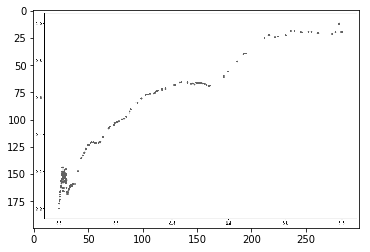

In [64]:
plt.imshow(img[0, :, :, 0],  cmap="gray")
plt.show()

In [65]:
model_config = {
    'inputs': dict(images=dict(shape=B('image_shape')),
                             labels={'shape': (1), 'name': 'targets'}),
    'body': dict(layout='cpna cpna cpna', filters=[64, 128, 256],
                 strides=2, pool_strides=1, kernel_size=3),
    'head': dict(layout='Pfa', activation=tf.math.softplus, units=1),
    'initial_block/inputs': 'images',
    'loss': 'mse',
    'optimizer': ('Momentum', {'use_nesterov': True, 'learning_rate': 0.01, 'momentum': 0.5})}

In [76]:
train_template = (Pipeline()
                  .init_variable('loss_history', init_on_each_run=list)
                  .init_model('dynamic', TFModel, 'image_model', config=model_config)
                  .to_array()
                  .train_model('image_model', fetches='loss',
                               feed_dict={'images': B('images'),
                                          'labels': B('target')}, 
                               save_to=V('loss_history'), mode='a'))

test_template = (Pipeline()
                  .init_variable('loss_history', init_on_each_run=list)
                  .import_model('image_model', train_pipeline)
                  .to_array()
                  .train_model('image_model', fetches='loss',
                               feed_dict={'images': B('images'),
                                          'labels': B('target')}, 
                               save_to=V('loss_history'), mode='a'))

In [77]:
train_pipeline = (load_ppl + train_template << train_set)
test_pipeline = (load_ppl + test_template << test_set)

ValueError: x and y must not be None

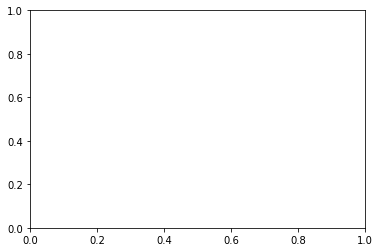

In [78]:
plt.plot(train_pipeline.get_variable('loss_history'))

In [70]:
train_pipeline.run(16, shuffle=True, n_epochs=5, drop_last=True, bar=True)
test_pipeline.run(16, shuffle=True, n_epochs=5, drop_last=True, bar=True)

 32%|███▏      | 30/95 [01:49<03:44,  3.45s/it]

KeyboardInterrupt: 

In [48]:
btch = (load_ppl << train_set).next_batch(2)

In [5]:
btch = (load_ppl << test_set).next_batch(2)